In [3]:
# import voronoi from scipy
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# generate point set to graph, sample is the five points from the paper with 2 edge removal cases, 
# rSample is a randomized set producing n points

### sample from paper
# sample = np.array([[0,0],[0.45,0.4],[0.9,0.25],[0.95,1],[1.5,0.75]])
# P = sample

### random sample
n = 10
rng = np.random.default_rng()
P = rng.random((n,2)) * 2 - 1

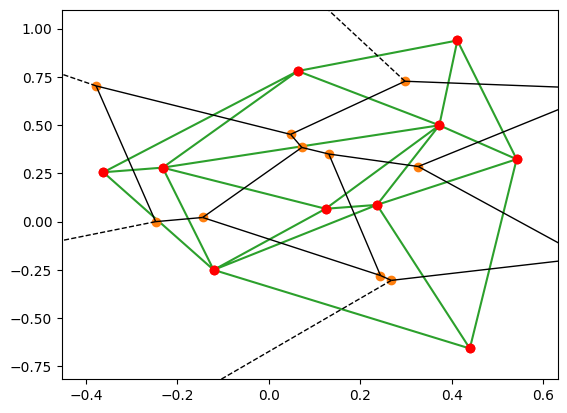

In [5]:
vor_t = Voronoi(P)
fig = voronoi_plot_2d(vor_t, point_size=10)
plt.plot(P[:,0], P[:,1], 'ro')

tris = Delaunay(P)
plt.plot(P[:,0], P[:,1], 'ro')
plt.triplot(P[:,0], P[:,1], tris.simplices.copy())

In [6]:
def boundGraph(pset,M):
    # need to add if to compare against original sample length so it doesnt repeatedly add points
    return np.append(pset, ([[M,0],[-M,0],[0,M],[0,-M]]), axis=0)

Pbound = boundGraph(P, 10)
vor = Voronoi(Pbound)

In [7]:
def dist(a,b):
    return np.sqrt((b[1] - a[1])**2 + (b[0] - a[0])**2)

def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def point_check(my_vor, p1, p1_idx, p2_idx, r):
    p1_reg = my_vor.point_region[p1_idx]
    p2_reg = my_vor.point_region[p2_idx]

    cn = np.intersect1d(my_vor.regions[p1_reg], my_vor.regions[p2_reg])
    if(cn.size > 0):
        if(cn[0] != -1 and cn[1] != -1):
            v1 = my_vor.vertices[cn[0]]
            v2 = my_vor.vertices[cn[1]]
            return (dist(v1,p1) <= r or dist(v2,p1) <= r)
        return False

def rlimit(my_vor, r, a):
    edges = list()
    P     = my_vor.points
    V     = my_vor.vertices
    rp    = my_vor.ridge_points
    rv    = my_vor.ridge_vertices

    for i in range(rp.shape[0]):
        u = P[rp[i]]
        v = V[rv[i]]

        if(not np.all(u)):
            continue

        u_idx = rp[i][0]
        uN_idx = rp[i][1]
        # if dist < 2a, add to different edge set for hyst
        if (intersect(u[0],u[1],v[0],v[1]) and (dist(u[0],u[1]) <= 2*r) and (dist(u[0],u[1]) >= 2*a)):
            edges.append(rp[i])
            continue
        else:
            if(point_check(my_vor, u[0], u_idx, uN_idx, r) == True):
                edges.append(rp[i])
                continue
    return np.array(edges)
    # return P[np.array(edges)]

In [16]:
this_r = 1
p_edges = rlimit(vor,(this_r/2),0)
print(p_edges.shape)
# print(p_edges)

(20, 2)


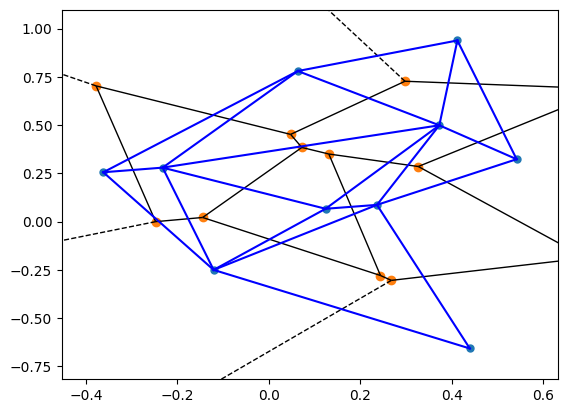

In [45]:
P_noBound = vor.points[0:vor.points.shape[0]-4]

NBvor = Voronoi(P_noBound)
fig = voronoi_plot_2d(NBvor, point_size=10)

plt.plot(P[:,0][p_edges.T], P[:,1][p_edges.T], linestyle='-', color='b')
plt.show()

We now have a graph containing points (birds) and edges (neighboring connections). Looking at the pseudocode, we will need a way to quickly access neighbors. We can turn our points and edges into an adjacency list. This function takes a set of points and edges and returns a dictionary where each index has a point, an empty array for position, velocity, and acceleration, and then a list off neighbors of that point

In [10]:
### INIT ###

# set collision shell a and sensing radius r
# init points and randomize velocities
shell = 0.5
r = 3
eps = r - np.sqrt(r*r - 4*shell*shell)
bound = 100

C:\Users\trist\AppData\Local\Temp\ipykernel_20064\1402149669.py:18: RuntimeWarning: divide by zero encountered in log10
  my_grad_y = np.log10(2 * np.abs(jy - iy) * ( ( 1 / ((jy-iy)*(jy-iy) - 4*shell*shell)**2 ) + ( 1 / (r*r - (jy-iy)*(jy-iy))**2 ) ))


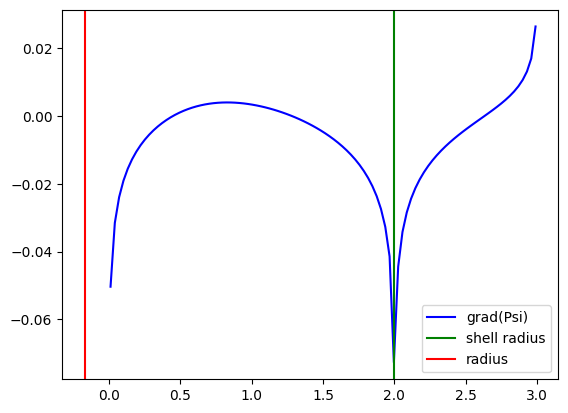

In [11]:
def Psi(sep):
    return 1/(sep*sep - 4*shell*shell) + 1/(r*r - sep*sep)

def norm(arr):
    return (arr - np.min(arr))/(np.max(arr) - np.min(arr))

def gradPsi(qi,qj):
    # break qi into ix, iy
    ix = qi[0]
    iy = qi[1]
    # break qj into jx, jy
    jx = qj[0]
    jy = qj[1]

    # partial derivatives of the potential function with respect to qi moving, in x and y respectively
    ### NEGATIVE REMOVED FOR LOG
    my_grad_x = np.log10(2 * np.abs(jx - ix) * ( ( 1 / ((jx-ix)*(jx-ix) - 4*shell*shell)**2 ) + ( 1 / (r*r - (jx-ix)*(jx-ix))**2 ) ))
    my_grad_y = np.log10(2 * np.abs(jy - iy) * ( ( 1 / ((jy-iy)*(jy-iy) - 4*shell*shell)**2 ) + ( 1 / (r*r - (jy-iy)*(jy-iy))**2 ) ))
    # my_grad_x = -2 * np.abs(jx - ix) * ( ( 1 / ((jx-ix)*(jx-ix) - 4*shell*shell)**2 ) + ( 1 / (r*r - (jx-ix)*(jx-ix))**2 ) )
    # my_grad_y = -2 * np.abs(jy - iy) * ( ( 1 / ((jy-iy)*(jy-iy) - 4*shell*shell)**2 ) + ( 1 / (r*r - (jy-iy)*(jy-iy))**2 ) )

    # rough normalization using log10/7
    return my_grad_x, my_grad_y
    # return my_grad_x, my_grad_y

x_temp = np.linspace(0.01,2.99,100)

y2 = -gradPsi((x_temp,0),(3,0))[0]/64
# print(y2)
# y2_log = -np.log10(y2)/7
# y2_norm = -norm(-y2_log)

plt.plot(x_temp, y2, '-b', label='grad(Psi)')
# plt.plot(x_temp, y2_log, '-b', label='log of grad(Psi)')
# plt.plot(x_temp, y2_norm, '--b', label='log grad(Psi) normalized')
plt.axvline(x=(3 - 2*shell), color='g', label='shell radius')
plt.axvline(x=3-(r+eps), color='r', label='radius')
plt.legend()

In [47]:
def normalize(vec):
    return vec / magsqrt(vec)

def magsqrt(vec):
    return np.sqrt(vec[0]**2 + vec[1]**2)

print(normalize((2,3)))
print([2/np.sqrt(13), 3/np.sqrt(13)])

# checks out

# set norm scale for adjList class
alpha_scale = 5
beta_scale  = 50

[0.5547002  0.83205029]
[0.5547001962252291, 0.8320502943378437]


In [48]:
class adjacencyList:
    def __init__(self, points, edges, r, eps, shell, *args):
        self.adjList = {}
        self.r = r
        self.eps = eps
        self.shell = shell
        self.points = np.copy(points)
        self.edges = np.copy(edges)

        if(args):
            print("using seed", args[0])
            rng = np.random.default_rng(args)
        else: 
            rng = np.random.default_rng()

        # fill out self.adjList based off init points and edges for each point
        for i in range(points.shape[0]):
            # neighbor finding code
            neighbors = np.append(edges[:,1][np.where(edges[:,0] == i)], 
                                  edges[:,0][np.where(edges[:,1] == i)])

            temp_n = list()
            for j in range(neighbors.shape[0]):
                this_dist = dist(points[i], points[neighbors[j]])
                if ((this_dist > (2*self.shell + self.eps)) and (this_dist < (self.r - self.eps))):
                    temp_n.append(neighbors[j])

            self.adjList[i] = {0 : np.zeros((3,2)), 1 : neighbors, 2 : np.array(temp_n)}
            self.adjList[i][0][0] = points[i]
            self.adjList[i][0][1] = (rng.random() * 2 - 1) * 0.1   # init random velocities
    
    # the look itself updates the adjList, so we need to update both the neighbors and the E' connections
    # update neighbor is called after step, so we want to take the voronoi, update points and edges of the 
    # adj list class, then update neighbor connections
    def update_neighbors(self):
        temp_edges = rlimit(Voronoi(boundGraph(self.points, bound)), self.r/2, self.shell)      # get points # take voronoi # take r limit
        self.edges = temp_edges

        # update neighbors
        for i in range(self.points.shape[0]):
            # new neighbors
            neighbors = np.append(self.edges[:,1][np.where(self.edges[:,0] == i)],
                                  self.edges[:,0][np.where(self.edges[:,1] == i)])

            n_diff = np.setdiff1d(neighbors, self.adjList[i][2])               # in neighbors but not E'(t)
            e_diff = np.setdiff1d(self.adjList[i][2], neighbors)               # in E'(t) but not neighbors at this step

            # print('n at idx ', i, neighbors)
            # print('En at idx', self.adjList[i][2])
            # print('diff of sets', n_diff, e_diff)

            # check over current neighbors in E but not E'
            for j in range(n_diff.size):
                temp_dist = dist(self.points[i], self.points[n_diff[j]])
                if ((temp_dist < (self.r - self.eps)) and (temp_dist > (2*self.shell + self.eps))):
                    self.adjList[i][2] = np.append(self.adjList[i][2], (n_diff[j]))
                # if i,f dne E'(t) and i,j \e E(t) and < r - eps, add to ePrime
            
            # check over edges in E' but not E
            self.adjList[i][2] = np.setdiff1d(self.adjList[i][2], e_diff)
            # if i,f \e E'(t) and i,j dne E(t), remove i,j from ePrime

            self.adjList[i][1] = neighbors

    def step(self):
        # calculate forces
        points_next = np.zeros((self.points.shape[0],2))
        for i in range(len(self.adjList)):
            alpha_i = np.zeros(2)
            beta_i = np.zeros(2)
            for j in range(len(self.adjList[i][2])):
                # find idx of each neighboring point in points list from class
                j_idx = self.adjList[i][2][j]

                pi = self.adjList[i][0][1]
                pj = self.adjList[j_idx][0][1]
                alpha_i -= (pi - pj)                           # alignment term

                qi = self.adjList[i][0][0]
                qj = self.adjList[j_idx][0][0]
                beta_i -= (gradPsi(qi,qj))                     # cohesion and seperation terms
        
            # normalize alpha and beta so they have the same influence
            if (magsqrt(alpha_i) > (1 / alpha_scale)):
                alpha_i = normalize(alpha_i) / alpha_scale
                
            if (magsqrt(beta_i) > (1 / beta_scale)):
                beta_i = normalize(beta_i) / beta_scale

            ui = (alpha_i + beta_i) / 2
            if (len(self.adjList[i][2]) > 0):
                ui /= len(self.adjList[i][2])

            # print(alpha_i, beta_i)
            # print(ui)
            self.adjList[i][0][2] = ui                         # ui = alpha_i + beta_i
            self.adjList[i][0][0] += self.adjList[i][0][1]     # qi += pi
            # self.adjList[i][0][1] += np.clip(self.adjList[i][0][1] + self.adjList[i][0][2], 0, 1)     # pi += ui
            self.adjList[i][0][1] += self.adjList[i][0][2]

            # also update point in points array for class to current pos
            points_next[i] = self.adjList[i][0][0]

        self.points = points_next

In [70]:
print('shell =', shell, ', r =', r, ', eps =', eps, ', bound =', bound)

num_agents = 50
n_points = rng.random((num_agents,2)) * 2 - 1

n_edges = rlimit(Voronoi(boundGraph(n_points, bound)),(r/2), shell)

shell = 0.5 , r = 3 , eps = 0.1715728752538097 , bound = 100


using seed 1000
step 0
50 100
[[ 0.77423629 -0.95714686]
 [ 0.00427715  0.00427715]
 [ 0.          0.        ]]


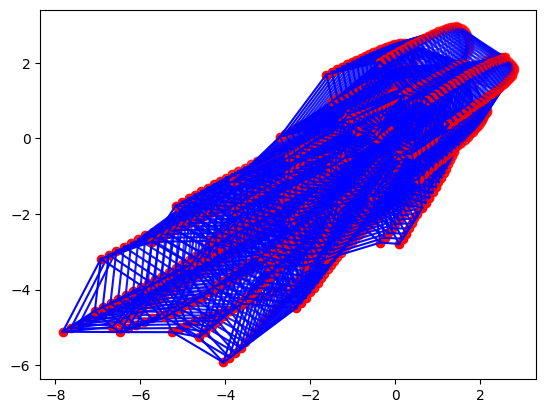

In [77]:
birds = adjacencyList(n_points, n_edges, r, eps, shell, 1000)

idx = 0
print('step 0')
print(len(birds.adjList), n_points.size)
print(birds.adjList[idx][0]) # position, velocity, acceleration
# print(birds.adjList[idx][1]) # adj list of neighbors in r-lim D
# print(birds.adjList[idx][2]) # adj list of E' neighbors

n_steps = 50
buff = 5
for n in range(buff,n_steps+buff):
    birds.step()
    birds.update_neighbors()

    # tris = Delaunay(birds.points)
    plt.plot(birds.points[:,0], birds.points[:,1], 'ro', alpha=(n/(n_steps+buff)))
    plt.plot(birds.points[:,0][birds.edges.T], birds.points[:,1][birds.edges.T], '-b', alpha=(n/(n_steps+buff)))
    # plt.show()

In [ ]:
# print(birds.init_state)

using seed 1000


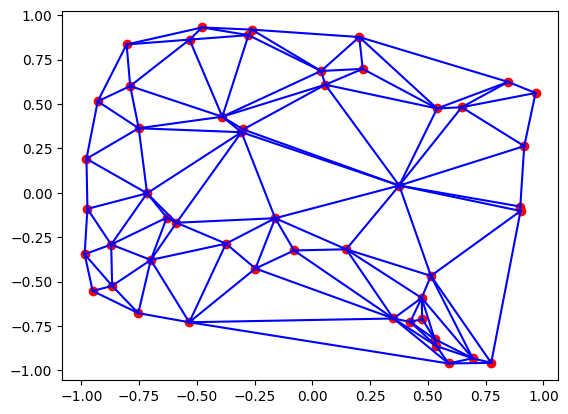

In [78]:
seed = 1000
birds = adjacencyList(n_points, n_edges, r, eps, shell, seed)
n = 0

plt.plot(birds.points[:,0], birds.points[:,1], 'ro')
plt.plot(birds.points[:,0][birds.edges.T], birds.points[:,1][birds.edges.T], '-b')
plt.show()

step 70
[[-5.30099757e+00 -7.52219303e+00]
 [-1.75002557e-01 -1.70657640e-01]
 [-2.48337049e-03 -1.72169731e-03]]
[-5.30099757 -7.52219303]


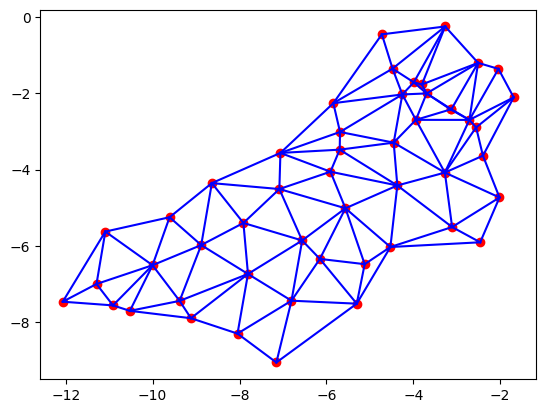

In [148]:
birds.step()
birds.update_neighbors()

plt.plot(birds.points[:,0], birds.points[:,1], 'ro')
plt.plot(birds.points[:,0][birds.edges.T], birds.points[:,1][birds.edges.T], '-b')

# plt.xlim([-10,10])
# plt.ylim([-10,10])

n += 1
print('step', n)
print(birds.adjList[idx][0])
print(birds.points[0])

Animation

In [26]:
from matplotlib.animation import FuncAnimation, PillowWriter
from time import localtime, strftime

In [154]:
gif_agents = 25
my_bound = 1000
# my_points = rng.random((gif_agents,2)) * 2 - 1

my_r = 2
my_shell = 0.1
my_eps = my_r - np.sqrt(my_r*my_r - 4*my_shell*my_shell)

my_edges = rlimit(Voronoi(boundGraph(my_points, my_bound)),(my_r/2),my_shell)

my_birds = adjacencyList(my_points, my_edges, my_r, my_eps, my_shell, 1000)

my_birds.step()
my_birds.update_neighbors()

using seed 1000


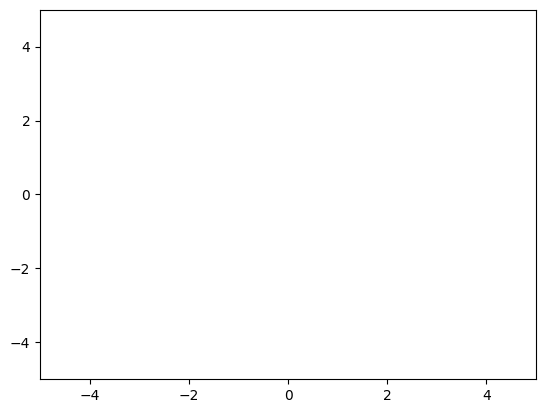

In [155]:
fig = plt.figure()  
width = 5
axis = plt.axes(xlim =(-width, width),
                ylim =(-width, width))

agents, = axis.plot([], [], 'ro')
line, = axis.plot([], [], '-b')

def init():
    agents.set_data([], [])
    line.set_data([], [])
    return agents, line,
   
def animate(i):
    my_birds.step()
    my_birds.update_neighbors()
    t_points = my_birds.points
    t_edges = my_birds.edges.T
    # print(t_points.shape, t_edges.shape)
    agents.set_data(t_points[:,0], t_points[:,1])
    # line.set_data(t_points[:,0][t_edges], t_points[:,1][t_edges])
    
    return agents, line,

# interval!!!!
anim = FuncAnimation(fig, animate, init_func = init, 
                     frames = 150, interval = 1000)

# 
time_str = strftime("%Y%m%d%H%M%S", localtime())
file_name = "agents_" + time_str + ".gif"

anim.save(filename=file_name, dpi=200, writer=PillowWriter(fps=30))

# anim method https://www.geeksforgeeks.org/using-matplotlib-for-animations/

Glitches out without long enough interval for functions to finish calculations. Lets time our step and update neighbor functions and find a good time interval

In [690]:
# https://stackoverflow.com/questions/7370801/how-do-i-measure-elapsed-time-in-python
import time

start = time.time()

i=0
while(i < 100000):
    print("hello")
    i+=1

end = time.time()
print(end - start)

hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hell

In [759]:
test_num = 200
test_bound = 100
test_points = rng.random((test_num,2)) * 2 - 1


print('func runtimes for ', test_num, ' agents')
runtimes = list()

start = time.time()
test_edges = rlimit(Voronoi(boundGraph(test_points, test_bound)),(my_r/2))
end = time.time()
print(len(runtimes), ': rlimit(Voronoi()), ', (end - start)*1000, 'ms')
runtimes.append((end-start))

start = time.time()
test_birds = adjacencyList(test_points, test_edges, my_r, my_eps, my_shell)
end = time.time()
print(len(runtimes), ': init(), ', (end - start)*1000, 'ms')
runtimes.append((end-start))

print('number of points and edges :', test_birds.points.shape[0], '|', test_birds.edges.shape[0])


start = time.time()
test_birds.step()
end = time.time()
print(len(runtimes), ': step(), ', (end - start)*1000, 'ms')
runtimes.append((end-start))

print('number of points and edges :', test_birds.points.shape[0], '|', test_birds.edges.shape[0])

start = time.time()
test_birds.update_neighbors()
end = time.time()
print(len(runtimes), ': update_neighbors(), ', (end - start)*1000, 'ms')
runtimes.append((end-start))

print('number of points and edges :', test_birds.points.shape[0], '|', test_birds.edges.shape[0])


start = time.time()
test_birds.step()
end = time.time()
print(len(runtimes), ': step() #2, ', (end - start)*1000, 'ms')
runtimes.append((end-start))

print('number of points and edges :', test_birds.points.shape[0], '|', test_birds.edges.shape[0])

start = time.time()
test_birds.update_neighbors()
end = time.time()
print(len(runtimes), ': update_neighbors() #2, ', (end - start)*1000, 'ms')
runtimes.append((end-start))

print('number of points and edges :', test_birds.points.shape[0], '|', test_birds.edges.shape[0])


start = time.time()
test_birds.step()
end = time.time()
print(len(runtimes), ': step() #3, ', (end - start)*1000, 'ms')
runtimes.append((end-start))

print('number of points and edges :', test_birds.points.shape[0], '|', test_birds.edges.shape[0])

start = time.time()
test_birds.update_neighbors()
end = time.time()
print(len(runtimes), ': update_neighbors() #3, ', (end - start)*1000, 'ms')
runtimes.append((end-start))

print('number of points and edges :', test_birds.points.shape[0], '|', test_birds.edges.shape[0])

print('max runtime,', np.max(runtimes) * 1000, 'ms, at idx', np.where(runtimes == np.max(runtimes))[0])

func runtimes for  200  agents
0 : rlimit(Voronoi()),  12.744426727294922 ms
1 : init(),  8.00943374633789 ms
number of points and edges : 200 | 574
2 : step(),  0.0 ms
number of points and edges : 200 | 574
3 : update_neighbors(),  35.01009941101074 ms
number of points and edges : 200 | 574
4 : step() #2,  8.427858352661133 ms
number of points and edges : 200 | 574
5 : update_neighbors() #2,  15.951156616210938 ms
number of points and edges : 200 | 575
6 : step() #3,  0.0 ms
number of points and edges : 200 | 575
7 : update_neighbors() #3,  34.97457504272461 ms
number of points and edges : 200 | 578
max runtime, 35.01009941101074 ms, at idx [3]


In [2610]:
def step10(bird):
    for i in range(10):
        bird.step()
        bird.update_neighbors()

    # tris = Delaunay(birds.points)
    plt.plot(bird.points[:,0], bird.points[:,1], 'ro')
    plt.plot(bird.points[:,0][bird.edges.T], bird.points[:,1][bird.edges.T], '-b')
    # plt.show()

using seed 191


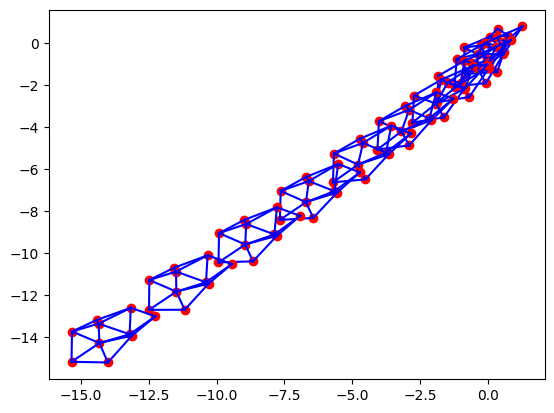

using seed 191


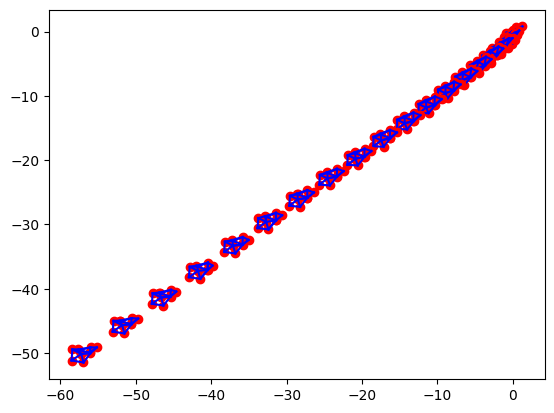

In [2611]:
my_seed = 191
birds = adjacencyList(n_points, n_edges, r, eps, shell, my_seed)
for i in range(10):
    step10(birds)
plt.show()

birds = adjacencyList(n_points, n_edges, r, eps, shell, my_seed)
for i in range(20):
    step10(birds)
plt.show()

In [ ]:
# tris = Delaunay(birds.points)
# plt.plot(birds.points[:,0], birds.points[:,1], 'ro')
# plt.triplot(birds.points[:,0], birds.points[:,1], tris.simplices.copy())